## Анализ логов с помощью ARIMA/ARIMAX

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
import time
import os
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, ConfusionMatrixDisplay
from pmdarima import auto_arima

### Подготовка датасета

Код для парсера логов drain

In [2]:
class Node:
    def __init__(self, child_id=None, depth=0, token=None):
        """
        Класс для узла дерева
        :param child_id: id всех лепестков дерева
        :param depth: уровень, на котором находится узел
        :param token: значение узла
        """
        if child_id is None:
            child_id = {}
        self.child_id = child_id
        self.depth = depth
        self.token = token


class LogCluster:
    def __init__(self, log_template='', log_id=None):
        """
        Кластер для хранения схожих логов
        :param log_template: Шаблон лога
        :param log_id: id строк логов с данным шаблоном
        """
        if log_id is None:
            log_id = []
        self.log_template = log_template
        self.log_id = log_id


class DrainParser:
    def __init__(self,
                 log_format,
                 input_dir,
                 output_dir,
                 depth=4,
                 similarity=0.4,
                 max_child=100,
                 save_parameters=False,
                 regex={},
                 ):
        """
        Класс для инициализации парсинга логов с помощью метода Drain
        :param log_format: Формат лога
        :param input_dir: Директория, где находится лог-файл
        :param output_dir: Директория, куда будут записаны результаты
        :param depth: максимальная глубина дерева
        :param similarity: схожесть сообщений в логах
        :param max_child: максимальное количество лепестков дерева с уровня 2 и ниже
        """
        self.log_format = log_format
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.depth = depth - 2
        self.similarity = similarity
        self.max_child = max_child
        self.root_node = Node()
        self.log_df = pd.DataFrame()
        self.save_parameters = save_parameters
        self.regex = regex

    def parse(self, log_name: str) -> None:
        headers, log_format_regex = self.generate_log_format_regex()
        self.log_df = self.load_to_dataframe(log_name, headers, log_format_regex)

        list_clusters = []

        count = 0

        time_start = time.perf_counter()

        for idx, line in self.log_df.iterrows():
            # len_df = len(self.log_df)

            log_id = line['log_id']
            # list_message = self.preprocess(line['Content']).strip().split()
            list_message = list(filter(lambda x: x != '', re.split(r'[\s=:,]', self.preprocess(line['Content']).strip())))

            match_cluster = self.tree_search(list_message)

            if match_cluster is None:
                new_cluster = LogCluster(list_message, [log_id])
                list_clusters.append(new_cluster)
                self.add_cluster_to_tree(new_cluster)

            else:
                new_template = self.get_template(list_message, match_cluster.log_template)
                match_cluster.log_id.append(log_id)
                if ' '.join(new_template) != ' '.join(match_cluster.log_template):
                    match_cluster.log_template = new_template

            count += 1
            if count % 1000 == 0 or count == len(self.log_df):
                print(
                    "Processed {0:.2f}% of log lines.".format(
                        count * 100.0 / len(self.log_df)
                    )
                )

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        print(f'\nTime taken: {time.perf_counter() - time_start:.4f} seconds')

        self.save_results(list_clusters, log_name)

    def load_to_dataframe(self, log_name: str, headers: list[str], log_format_regex: re.Pattern[str]) -> pd.DataFrame:
        """
        Загрузка логов в датафрейм
        :param log_name: Наименование файла логов
        :param headers: Заголовки датафрейма
        :param log_format_regex: Регулярное выражение для парсинга строк
        :return: pd.DataFrame()
        """
        df_dict = {header: [] for header in headers}
        skipped_lines = 0

        print('Starting loading logs to dataframe')

        with open(Path(self.input_dir, log_name), 'r', encoding='utf-8') as f:
            for line in f.readlines():
                # В случае отсутствия одного из параметров, сообщение будет пропущено
                try:
                    match = re.match(log_format_regex, line.strip())
                    for header in df_dict:
                        df_dict[header].append(match.group(header).strip())
                except AttributeError:
                    skipped_lines += 1

        df = pd.DataFrame(df_dict)
        df.insert(0, 'log_id', [i for i in range(1, len(df) + 1)])

        print(f'Dataframe was loaded, {skipped_lines} messages was skipped, due to missing parameter in log message')

        return df

    def generate_log_format_regex(self) -> (list[str], re.Pattern[str]):
        """
        Генерация регулярного выражения для парсинга строк
        :return: headers: list, log_format_regex: regular expression
        """
        headers = []
        log_format_regex = ''
        split_log_format = re.split(r'(<[^<>]+>)', self.log_format)

        for i, name in enumerate(split_log_format):
            if i % 2 == 0:
                log_format_regex += re.sub(r'\s+', '\\\s+', name)
            else:
                header = name.strip('<>')
                headers.append(header)
                log_format_regex += rf'(?P<{header}>.+?)'

        log_format_regex = re.compile('^' + log_format_regex + '$')

        return headers, log_format_regex

    def preprocess(self, string):
        for symbol, rex in self.regex.items():
            string = re.sub(rex, symbol, string)
        return string
        
    def tree_search(self, sequence: list[str]) -> LogCluster or None:
        """
        Поиск наиболее подходящего кластера по дереву
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        len_sequence = len(sequence)
        matched_cluster = None

        if len_sequence not in self.root_node.child_id:
            return matched_cluster

        parent_node = self.root_node.child_id[len_sequence]
        current_depth = 1
        for token in sequence:
            if current_depth >= self.depth or current_depth > len_sequence:
                break

            if token in parent_node.child_id:
                parent_node = parent_node.child_id[token]
            elif "<*>" in parent_node.child_id:
                parent_node = parent_node.child_id["<*>"]
            else:
                return matched_cluster
            current_depth += 1

        possible_cluster = parent_node.child_id

        matched_cluster = self.find_match(possible_cluster, sequence)

        return matched_cluster

    def find_match(self, cluster: list[LogCluster], sequence: list[str]) -> LogCluster or None:
        """
        Нахождение наиболее схожего кластера
        :param cluster: список из LogCluster
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        max_similarity = 0
        max_number_of_similar_params = 0
        matched_cluster = None

        for cl in cluster:
            similarity, number_of_parameters = self.check_similarity(cl.log_template, sequence)
            if (similarity > max_similarity or
                    (similarity == max_similarity and number_of_parameters > max_number_of_similar_params)):
                max_similarity = similarity
                max_number_of_similar_params = number_of_parameters
                matched_cluster = cl

        if max_similarity < self.similarity:
            return None

        return matched_cluster

    def check_similarity(self, template: list[str], sequence: list[str]) -> (float, int):
        """
        Проверка схожести c шаблоном
        :param template: шаблон
        :param sequence: список слов в сообщении
        :return: схожесть; количество параметров, отмеченных <*>
        """
        similar_tokens, number_of_parameters = 0, 0
        for token_1, token_2 in zip(template, sequence):
            if token_1 == '<*>':
                number_of_parameters += 1
            elif token_1 == token_2:
                similar_tokens += 1

        similarity = similar_tokens / len(sequence)

        return similarity, number_of_parameters

    def add_cluster_to_tree(self, cluster: LogCluster) -> None:
        """
        Добавление кластера к дереву
        :param cluster: LogCluster
        :return: None
        """
        len_sequence = len(cluster.log_template)
        if len_sequence not in self.root_node.child_id:
            first_layer_node = Node(depth=1, token=len_sequence)
            self.root_node.child_id[len_sequence] = first_layer_node
        else:
            first_layer_node = self.root_node.child_id[len_sequence]

        parent_node = first_layer_node

        current_depth = 1
        for token in cluster.log_template:
            if current_depth >= self.depth or current_depth > len_sequence:
                if len(parent_node.child_id) == 0:
                    parent_node.child_id = [cluster]
                else:
                    parent_node.child_id.append(cluster)
                break

            if token not in parent_node.child_id:
                current_number_of_child = len(parent_node.child_id)

                if not any(char.isdigit() for char in token):
                    if '<*>' in parent_node.child_id:
                        if current_number_of_child < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        else:
                            parent_node = parent_node.child_id['<*>']
                    else:
                        if current_number_of_child + 1 < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        elif current_number_of_child + 1 == self.max_child:
                            new_node = Node(depth=current_depth + 1, token='<*>')
                            parent_node.child_id['<*>'] = new_node
                            parent_node = new_node
                else:
                    if '<*>' in parent_node.child_id:
                        parent_node = parent_node.child_id['<*>']
                    else:
                        new_node = Node(depth=current_depth + 1, token='<*>')
                        parent_node.child_id['<*>'] = new_node
                        parent_node = new_node
            else:
                parent_node = parent_node.child_id[token]

            current_depth += 1

    def get_template(self, new_sequence: list[str], old_sequence: list[str]) -> list[str]:
        """
        Создание шаблона сообщения
        :param new_sequence: Новое сообщение в текущем логе
        :param old_sequence: Старое сообщение, которое хранится в шаблоне кластера
        :return: Новый шаблон
        """
        new_template = []

        for word_1, word_2 in zip(new_sequence, old_sequence):
            if word_1 == word_2:
                new_template.append(word_1)
            else:
                new_template.append('<*>')

        return new_template

    def save_results(self, clusters: list[LogCluster], log_file: str) -> None:
        """
        Сохранение результатов в формате csv
        :param clusters: все добавленные кластеры
        :param log_file: имя файла
        :return: None
        """
        log_templates = [pd.NA] * len(self.log_df)
        log_templates_id = [pd.NA] * len(self.log_df)
        df_events = []
        id_counter = 1

        print('Starting preparing results to save them to .csv file.')

        for cluster in clusters:
            template = ' '.join(cluster.log_template)
            occurrence = len(cluster.log_id)
            hex_id = id_counter # Вариант с хешем int(str(hash(template))[:8])
            for idx in cluster.log_id:
                idx -= 1
                log_templates[idx] = template
                log_templates_id[idx] = hex_id
            df_events.append([hex_id, template, occurrence])
            id_counter += 1

        self.log_df['Event_id'] = log_templates_id
        self.log_df['Event_template'] = log_templates
        if self.save_parameters:
            self.log_df['parameters'] = self.log_df.apply(self.get_parameter_list, axis=1)

        print('Results was prepared.')
        print(f'Saving dataframe to {Path(self.output_dir, log_file + '_structured.csv')}')

        self.log_df.to_csv(Path(self.output_dir, log_file + '_structured.csv'), index=False)

        print(f'Saving templates to {Path(self.output_dir, log_file + '_templates.csv')}')

        event_df = pd.DataFrame(df_events, columns=['Event_id', 'Event_template', 'Occurrence'])
        event_df.sort_values(by='Event_id').to_csv(Path(self.output_dir, log_file + '_templates.csv'), index=False)

    def get_parameter_list(self, row) -> list:
        """
        Для создания столбца параметров, которые скрываются за <*>
        :param row: строка из DataFrame
        :return: список подставляемых значений
        """
        result_row = []
        if '<*>' not in row['Event_template']:
            return result_row

        token_list = list(filter(lambda x: x != '', re.split(r'[\s=:,]', row['Content'].strip())))
        template_list = row['Event_template'].split()

        for i, template_token in enumerate(template_list):
            if template_token == '<*>':
                result_row.append(token_list[i])

        # Вариант с регулярками плохо работает,
        # так как в этом случае разделение первоначальной строки надо делать только по пробелам

        # regex = re.sub(r'([^A-Za-z0-9])', r'\\\g<1>', row['Event_template'])
        # regex = re.sub(r'\\\s+', r'\\s+', regex)
        # regex = '^' + re.sub(r'\\<\\\*\\>', r'(.*?)', regex) + '$'
        # result_row = re.findall(regex, row['Content'])
        # result_row = list(result_row[0]) if isinstance(result_row[0], tuple) else [result_row[0]]

        return result_row

<>:146: SyntaxWarning: invalid escape sequence '\s'
<>:146: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_12296\3528957452.py:146: SyntaxWarning: invalid escape sequence '\s'
  log_format_regex += re.sub(r'\s+', '\\\s+', name)


Парсинг логов

In [3]:
inp_dir = r'HDFS_v1'
out_dir = r'templates\\drain\\'
log = r'HDFS.log'
format_log = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
regex = {"<IP>": r'/?\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+'}
drain = DrainParser(format_log, inp_dir, out_dir, similarity=0.4, depth=4, max_child=100, save_parameters=False, regex=regex)
drain.parse(log)

Starting loading logs to dataframe
Dataframe was loaded, 0 messages was skipped, due to missing parameter in log message
Processed 0.01% of log lines.
Processed 0.02% of log lines.
Processed 0.03% of log lines.
Processed 0.04% of log lines.
Processed 0.04% of log lines.
Processed 0.05% of log lines.
Processed 0.06% of log lines.
Processed 0.07% of log lines.
Processed 0.08% of log lines.
Processed 0.09% of log lines.
Processed 0.10% of log lines.
Processed 0.11% of log lines.
Processed 0.12% of log lines.
Processed 0.13% of log lines.
Processed 0.13% of log lines.
Processed 0.14% of log lines.
Processed 0.15% of log lines.
Processed 0.16% of log lines.
Processed 0.17% of log lines.
Processed 0.18% of log lines.
Processed 0.19% of log lines.
Processed 0.20% of log lines.
Processed 0.21% of log lines.
Processed 0.21% of log lines.
Processed 0.22% of log lines.
Processed 0.23% of log lines.
Processed 0.24% of log lines.
Processed 0.25% of log lines.
Processed 0.26% of log lines.
Processed

In [4]:
df_templated = pd.read_csv(r'templates\\drain\\HDFS.log_structured.csv')

In [5]:
df_templated.head()

,log_id,Date,Time,Pid,Level,Component,Content,Event_id,Event_template
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,2,BLOCK* NameSystem.allocateBlock <*> <*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,3,PacketResponder <*> for block <*> <*>


In [154]:
# с помощью метода будем вытаскивать значения block_id, чтобы соотнести с размеченными данными
def block_parse(row):
    row = str(row)
    pattern = re.compile(r'blk_-?\d+', re.IGNORECASE)
    match = re.search(pattern, row)
    if match:
        return match[0]
    else:
        return None

In [7]:
df_templated['block_id'] = df_templated['Content'].apply(block_parse)

In [10]:
anomaly_label = pd.read_csv(r'HDFS_v1\\preprocessed\\anomaly_label.csv')

In [11]:
df_templated['anomaly'] = df_templated['block_id'].map(anomaly_label.set_index('BlockId').to_dict()['Label'])

Процент аномалий

In [155]:
print(f'Процент аномалий в датасете: {len(df_templated[df_templated['anomaly'] == 'Anomaly']) / len(df_templated) * 100:.2f}%')

Процент аномалий в датасете: 2.58%


**Преобразование дат**

In [156]:
# во время парсинга даты и время переводятся в int, соответственно ведущие нули убираются и необходимо из восстановить
def normalize_time(row):
    row = str(row)
    if len(row) < 6:
        return row.zfill(6)
    return row

In [107]:
df_templated['Time'] = df_templated['Time'].apply(normalize_time)
df_templated['Date'] = df_templated['Date'].apply(normalize_time)

In [108]:
df_templated['raw_time'] = df_templated['Date'].astype(str) + ' ' + df_templated['Time'].astype(str)

In [111]:
df_templated['timestamp'] = pd.to_datetime(df_templated['raw_time'], format='%y%m%d %H%M%S')

In [113]:
frequency = '30s'

In [114]:
df_templated['interval'] = df_templated['timestamp'].dt.floor(frequency)

**Итоговый преобработанный датасет**

In [115]:
df_templated.head()

,log_id,Date,Time,Pid,Level,Component,Content,Event_id,Event_template,block_id,anomaly,raw_time,timestamp,interval
0,1,081109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>,blk_-1608999687919862906,Normal,081109 203518,2008-11-09 20:35:18,2008-11-09 20:35:00
1,2,081109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,2,BLOCK* NameSystem.allocateBlock <*> <*>,blk_-1608999687919862906,Normal,081109 203518,2008-11-09 20:35:18,2008-11-09 20:35:00
2,3,081109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>,blk_-1608999687919862906,Normal,081109 203519,2008-11-09 20:35:19,2008-11-09 20:35:00
3,4,081109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,1,Receiving block <*> src <IP> dest <IP>,blk_-1608999687919862906,Normal,081109 203519,2008-11-09 20:35:19,2008-11-09 20:35:00
4,5,081109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,3,PacketResponder <*> for block <*> <*>,blk_-1608999687919862906,Normal,081109 203519,2008-11-09 20:35:19,2008-11-09 20:35:00


### ARIMAX

**Создаем временной ряд для модели `SARIMAX`**

In [116]:
df_time_series = df_templated.groupby('interval').agg(
    logs_count=('Level', 'count'),
    info_logs=('Level', lambda x: (x == 'INFO').sum()),
    warn_logs=('Level', lambda x: (x == 'WARN').sum()),
    err_logs=('Level', lambda x: (x == 'ERROR').sum()),
    anomaly_count=('anomaly', lambda x: (x == 'Anomaly').sum()),
    anomaly_part=('anomaly', lambda x: (x == 'Anomaly').sum() / x.count()),
    block_id_anomaly_count=('block_id', lambda x: x[df_templated.loc[x.index, 'anomaly'] == 'Anomaly'].nunique()),
    block_id_normal_count=('block_id', lambda x: x[df_templated.loc[x.index, 'anomaly'] == 'Normal'].nunique())
)
df_time_series = df_time_series.asfreq(frequency)

In [117]:
df_time_series.head()

,logs_count,info_logs,warn_logs,err_logs,anomaly_count,anomaly_part,block_id_anomaly_count,block_id_normal_count
interval,,,,,,,,
2008-11-09 20:35:00,201,201,0,0,84,0.417910,1,4
2008-11-09 20:35:30,2005,2005,0,0,164,0.081796,8,405
2008-11-09 20:36:00,3718,3718,0,0,69,0.018558,14,566
2008-11-09 20:36:30,3430,3430,0,0,62,0.018076,12,540
2008-11-09 20:37:00,3752,3752,0,0,106,0.028252,17,581


Разбиение на train и test

In [118]:
index = int(len(df_time_series)*0.8)
df_train = df_time_series.iloc[:index].copy()
df_test = df_time_series.iloc[index:].copy()

Так как мы хотим научить модель прогнозировать нормальное поведение, то удаляем из неё аномальные значение. В данном случае у нас будет прогноз на количество логов за 30 секунд. Из общего количества убираем логи, которые относятся к аномалии.

In [119]:
df_train_normal = df_train.copy()
df_train_normal['logs_count'] = df_train_normal['logs_count'] - df_train_normal['anomaly_count']

Проверка на стационарность. В качестве критерия берем $p-value \leq 0.05$ 

In [120]:
def check_stationarity(timeseries):
    print('===========Check stationarity===========')
    test = adfuller(timeseries.dropna(), autolag='AIC')
    output = pd.Series(test[:4],
                      index=['Тестовая статистика', 'p-value',
                             'Количество лагов', 'Количество наблюдений'])

    for key, value in test[4].items():
        output[f'Критическое значение ({key})'] = value

    print(output)

    if test[1] <= 0.05:
        print('\nВывод: ряд стационарный (p-value <= 0.05)')
    else:
        print('\nВывод: ряд не стационарный. Требуется дифференцирование')

In [121]:
check_stationarity(df_train_normal['logs_count'])

===========Check stationarity===========
Тестовая статистика          -1.073805e+01
p-value                       2.865080e-19
Количество лагов              8.000000e+00
Количество наблюдений         3.705000e+03
Критическое значение (1%)    -3.432116e+00
Критическое значение (5%)    -2.862320e+00
Критическое значение (10%)   -2.567185e+00
dtype: float64

Вывод: ряд стационарный (p-value <= 0.05)


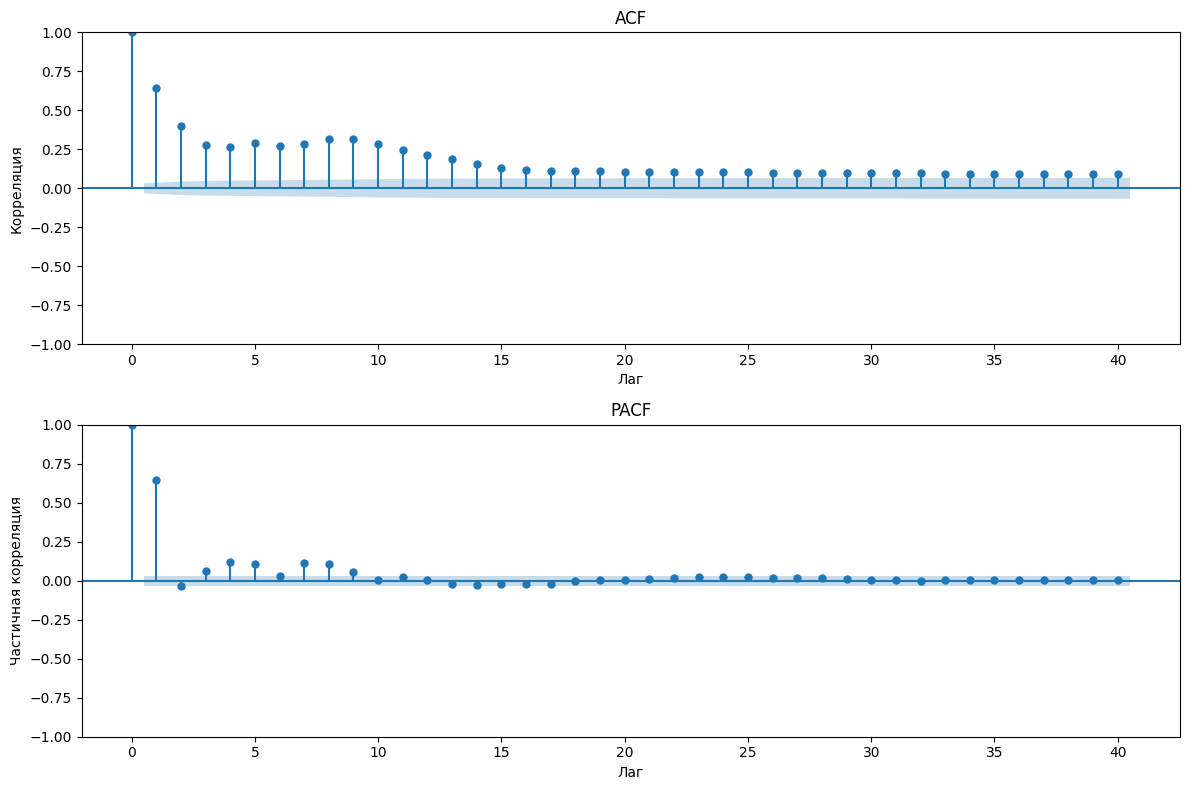

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_train_normal['logs_count'].dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF')
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('Корреляция')

plot_pacf(df_train_normal['logs_count'].dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF')
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('Частичная корреляция')

plt.tight_layout()

Так как ACF затухает плавно, то будем применять дифференцирование

Проверим, что происходит при дифференцировании

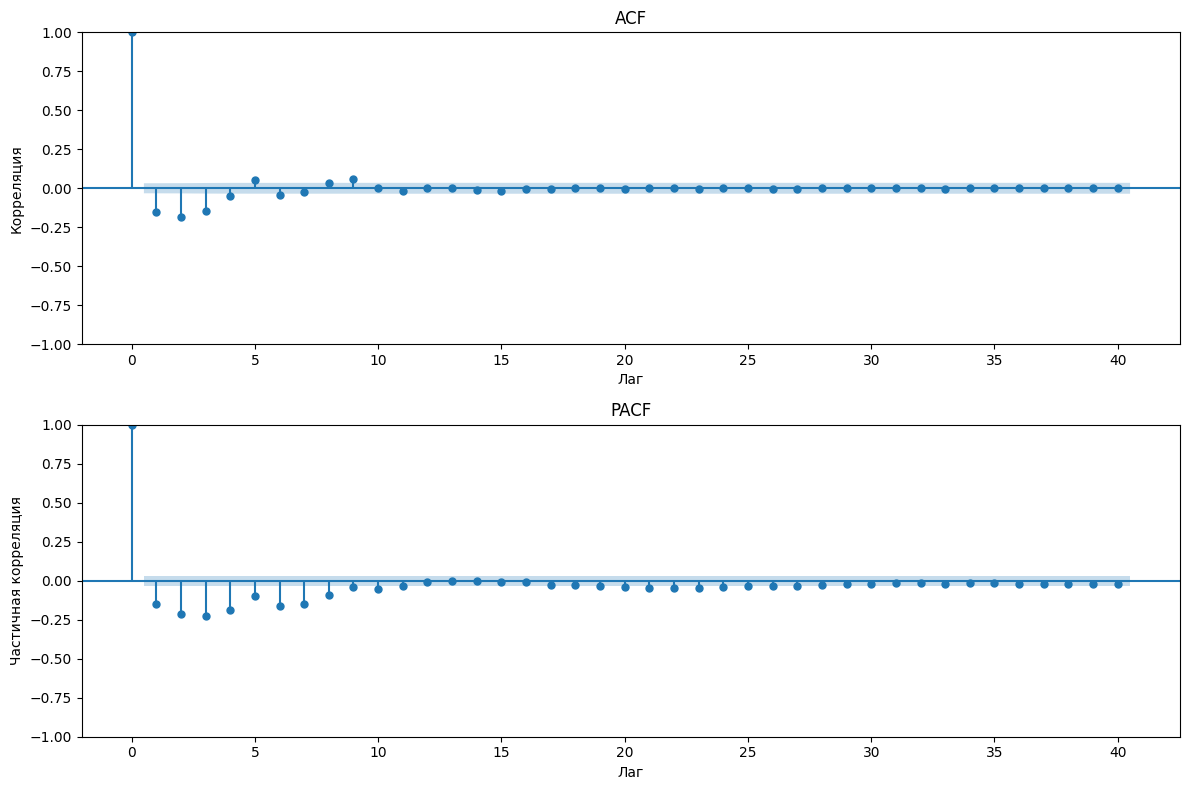

In [123]:
diff_df_train = df_train_normal.diff()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(diff_df_train['logs_count'].dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF')
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('Корреляция')

plot_pacf(diff_df_train['logs_count'].dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF')
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('Частичная корреляция')

plt.tight_layout()
plt.show()

В целом ситуация улучшилась, но теперь есть ощущение, что мы передифференцировались. Но оставим это так и проверим, как себя поведет модель.

Добавление экзогенных признаков в модель. В данном случае добавляю количество `block_id` в промежутке времени. Это поможет отлавливать пики.

In [124]:
exog = df_time_series['block_id_normal_count']
train_exog = exog.iloc[:index]
test_exog = exog.iloc[index:]

Обучаем модель, с параметрами $p=9$, $d=1$, $q=4$.

In [125]:
sarimax_model = SARIMAX(endog=df_train_normal['logs_count'],
                        exog=train_exog,
                        order=(9, 1, 4),
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                       )

sarimax_model_fit = sarimax_model.fit()

predictions_sarimax = sarimax_model_fit.forecast(steps=len(df_test), 
                                                 exog=test_exog,
                                                )

D:\лапки\hse\team_project\checkpoint_3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             logs_count   No. Observations:                 3714
Model:               SARIMAX(9, 1, 4)   Log Likelihood              -29544.089
Date:                Mon, 08 Dec 2025   AIC                          59118.179
Time:                        23:18:05   BIC                          59211.436
Sample:                    11-09-2008   HQIC                         59151.366
                         - 11-11-2008                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
block_id_normal_count     2.9080      0.001   2375.280      0.000       2.906       2.910
ar.L1                     0.7327      0.136      5.372      0.000       0.465       1.000
ar.L2   

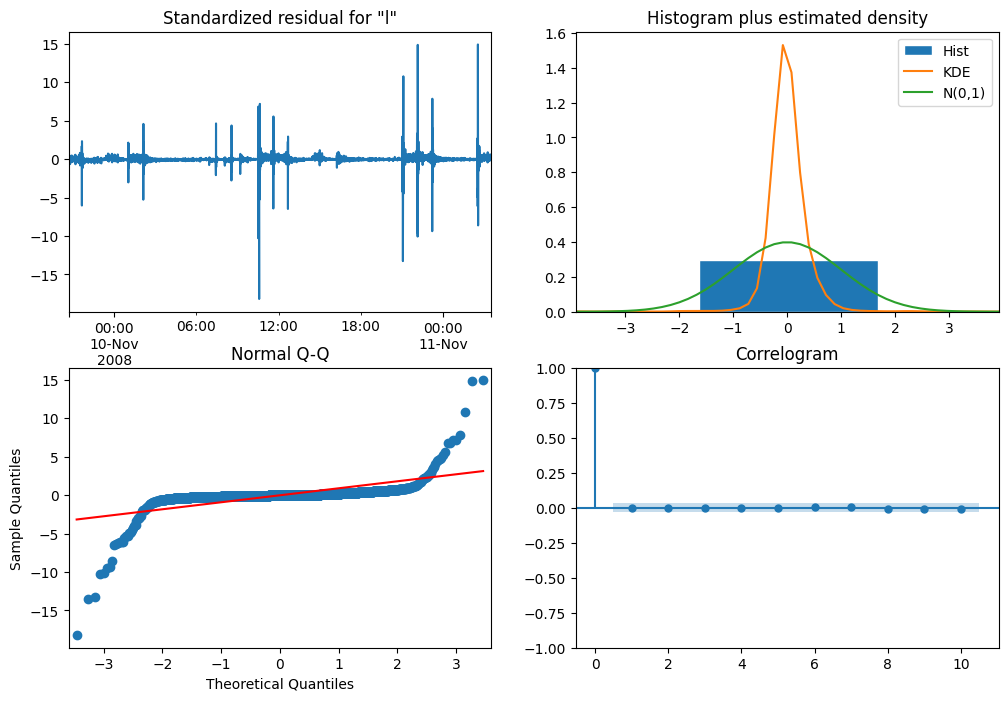

In [126]:
print(sarimax_model_fit.summary())

sarimax_model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

Тут стоит отметить, что очевидно в логах нет равномерной структуры и есть скачки в количестве сообщений. Поэтому можно видеть, что шумы хоть и близки к нулю, но всё равно имеют пики, которые модель не смогла уловить. Также можно отметить, что в остатках отсутствует автокорреляция.

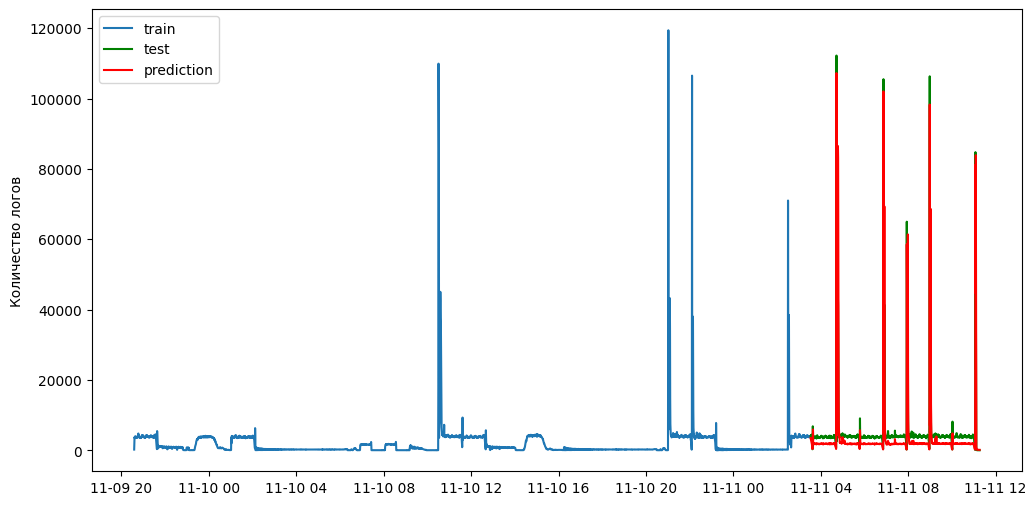

In [160]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train.index, df_train['logs_count'], label='train')
ax.plot(df_test.index, df_test['logs_count'], color='green', label='test')
ax.plot(df_test.index, predictions_sarimax, color='red', label='prediction')
ax.set_ylabel('Количество логов')
ax.legend()
plt.show()

Теперь найдем аномалии. В качестве критерия принимаем превышение количества логов на $3 \sigma$

In [147]:
sigma_sarimax_train = sarimax_model_fit.resid.std()

In [148]:
test_residuals = df_test['logs_count'] - predictions_sarimax

In [149]:
is_anomaly = np.abs(test_residuals) > 3 * sigma_sarimax_train

In [150]:
rmse = np.sqrt(mean_squared_error(df_test['logs_count'], predictions_sarimax))
print(f'RMSE на тестовых данных: {rmse:.3f}')

RMSE на тестовых данных: 4341.720


In [169]:
result = pd.DataFrame(np.zeros((len(df_test), 2)), columns=['ground_truth', 'predicted'])
result['ground_truth'] = np.where(df_test['anomaly_count'] > 0, 'Anomaly', 'Normal')
result['predicted'] = np.where(np.abs(df_test['logs_count']) > 3 * sigma_sarimax_train, 'Anomaly', 'Normal')

Получаем основные метрики

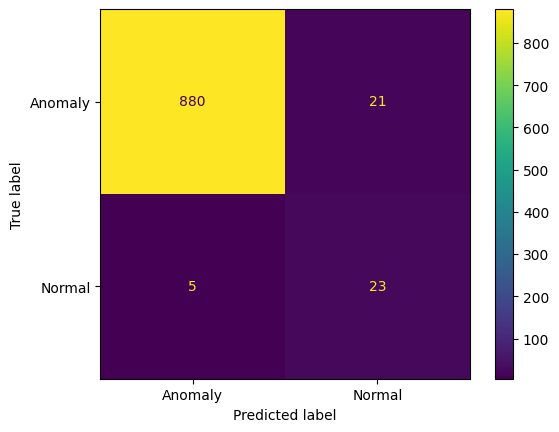

In [170]:
cm = confusion_matrix(result['ground_truth'], result['predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
disp.plot()
plt.show()

In [171]:
cr = classification_report(result['ground_truth'], result['predicted'])
print(cr)

              precision    recall  f1-score   support

     Anomaly       0.99      0.98      0.99       901
      Normal       0.52      0.82      0.64        28

    accuracy                           0.97       929
   macro avg       0.76      0.90      0.81       929
weighted avg       0.98      0.97      0.97       929



**Выводы по полученным результатам:**
- Изначально в данных присутствует большой дисбаланс;
- Хорошие метрики при предсказании аномалии, но плохие метрики для предсказания нормального состояния. Модель плохо отличает нормальные данные от аномалии;
- Возможно стоит уменьшить шаг по времени при сэмплировании временного ряда, чтобы было больше моментов времени с нормальным состоянием;
- Для обучения подобной модели стоит использовать датасет только с нормальным состоянием без аномалий. При этом желательно иметь большой промежуток времени, чтобы модель научилась улавливать всевозможные нормальные состояния системы.

### ARIMA

Рассмотрим на `auto_arima`

In [173]:
auto_arima_model = auto_arima(df_train_normal['logs_count'], 
                              d=None,
                              max_d=2,
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=71575.516, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=74109.130, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=71776.677, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=72506.179, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=71641.748, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=71776.671, Time=0.79 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=71533.837, Time=2.97 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=71566.434, Time=0.94 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=71565.846, Time=1.19 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=71539.781, Time=3.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=71560.306, Time=1.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=71548.257, Time=0.96 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=71533.603, Time=3.83 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=71541.627, Time=4.42 sec
 ARIMA(4,0,4)(0,0,0

In [175]:
predictions_auto_arima = auto_arima_model.predict(n_periods=len(df_test))

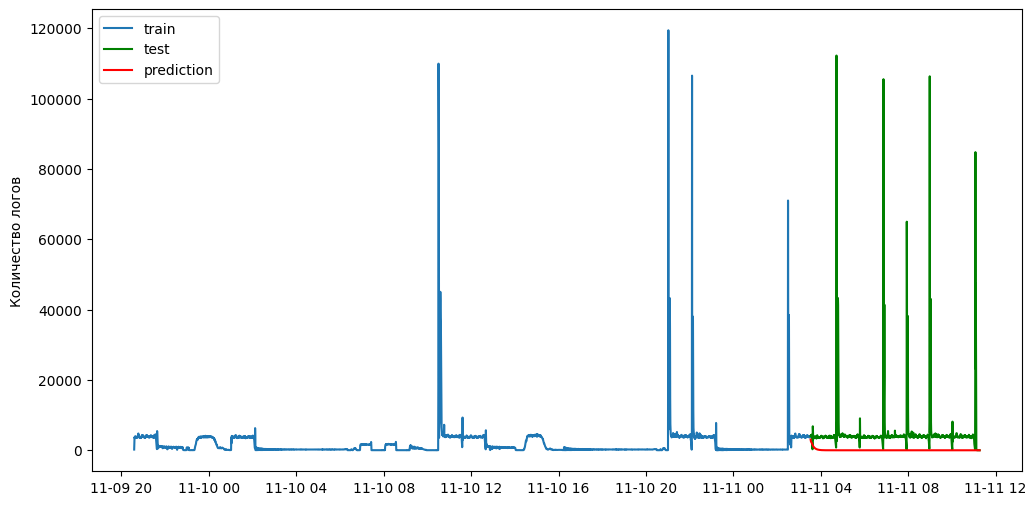

In [176]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_train.index, df_train['logs_count'], label='train')
ax.plot(df_test.index, df_test['logs_count'], color='green', label='test')
ax.plot(df_test.index, predictions_auto_arima, color='red', label='prediction')
ax.set_ylabel('Количество логов')
ax.legend()
plt.show()

In [177]:
sigma_auto_arima_train = auto_arima_model.resid().std()

In [178]:
test_residuals_auto = df_test['logs_count'] - predictions_auto_arima

is_anomaly = np.abs(test_residuals_auto) > 3 * sigma_auto_arima_train

In [179]:
rmse = np.sqrt(mean_squared_error(df_test['logs_count'], predictions_auto_arima))
print(f'RMSE на тестовых данных: {rmse:.3f}')

RMSE на тестовых данных: 9927.697


In [180]:
result_auto = pd.DataFrame(np.zeros((len(df_test), 2)), columns=['ground_truth', 'predicted'])
result_auto['ground_truth'] = np.where(df_test['anomaly_count'] > 0, 'Anomaly', 'Normal')
result_auto['predicted'] = np.where(np.abs(df_test['logs_count']) > 3 * sigma_auto_arima_train, 'Anomaly', 'Normal')

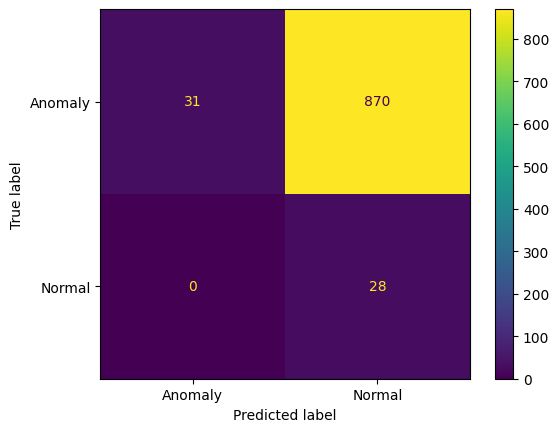

In [188]:
cm = confusion_matrix(result_auto['ground_truth'], result_auto['predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
disp.plot()
plt.show()

In [189]:
cr = classification_report(result_auto['ground_truth'], result_auto['predicted'])
print(cr)

              precision    recall  f1-score   support

     Anomaly       1.00      0.03      0.07       901
      Normal       0.03      1.00      0.06        28

    accuracy                           0.06       929
   macro avg       0.52      0.52      0.06       929
weighted avg       0.97      0.06      0.07       929



**Выводы:**
- Модель себя показывает значительно хуже модели `ARIMAX`;
- Модель не может учесть резкий рост количества сообщений в некоторые моменты времени, даже при нормальном состоянии системы.
- Так как модель плохо учитывает резкий рост количества логов, то получается большое стандартное отклонение. В связи с этим модель считает нормальным большие отклонения от её прогноза.
- Можно сделать вывод, что данная модель не подходит для анализа логов.